# 计算一定输入电流、一定出口温度下不同碱液流量对应的AWE制氢功耗

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置字体为支持中文的字体，如SimHei（黑体）
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

from Model.Static_Model.Static_Electrolyzer_Model_Hyzenis import AWE_Electrolyzer

## 实例化电解槽

In [4]:
AWE_Electrolyzer = AWE_Electrolyzer(Diameter_Electrode = 560 * 1E-3,
                                    Width_Cell = 5 * 1E-3,
                                    Num_Cells = 31,
                                    Lye_flow_min = 0.3,
                                    Lye_flow_max = 0.5,
                                    Static_Electrochemical_params_file_path = r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth',
                                    Static_Thermal_params_file_path = r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Thermal_params_Hyzenis.pth')

## 画出极化曲线

d:\Devs\Single_Stack_MLJ\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


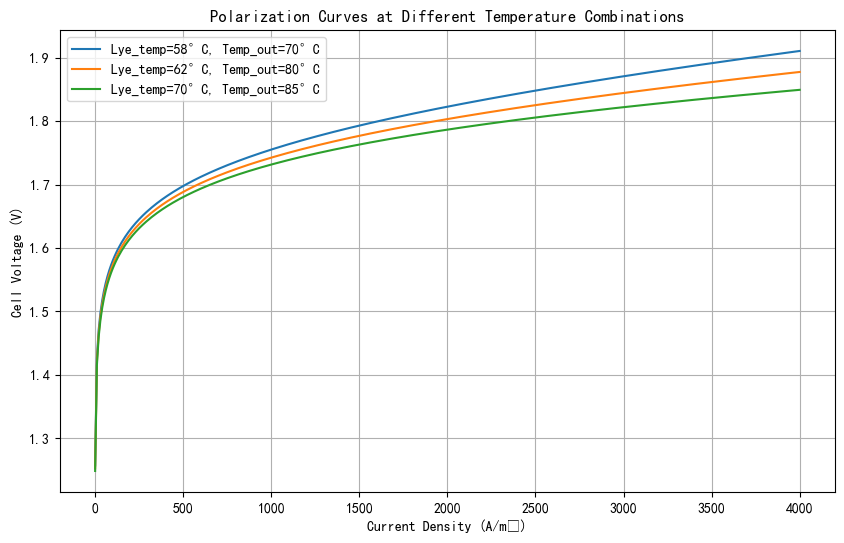

In [5]:
# 定义电流密度范围
current_densities = np.linspace(0, 4000, 400)

# 定义温度组合
temperature_combinations = [(58, 70), (62, 80), (70, 85)]

# 碱液流量和压力
Lye_flow = 0.45
Pressure = 1.6

# 初始化绘图
plt.figure(figsize=(10, 6))

# 遍历不同的温度组合
for Lye_temp, Temp_out in temperature_combinations:
    # 计算每个电流密度下的电池电压
    voltages = []
    for Current_density in current_densities:
        Vcell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp, Temp_out, Current_density, Lye_flow, Pressure)
        voltages.append(Vcell)

    # 绘制极化曲线
    plt.plot(current_densities, voltages, label=f'Lye_temp={Lye_temp}°C, Temp_out={Temp_out}°C')

# 设置图表标题和标签
plt.title('Polarization Curves at Different Temperature Combinations')
plt.xlabel('Current Density (A/m²)')
plt.ylabel('Cell Voltage (V)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

## 画出不同出口温度、不同流量下入口温度map图

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array = np.array([])  # 入口温度记录
V_cell_array = np.array([])
Power_H_array = np.array([])
X, Y = np.meshgrid(temp_out_array, lye_flow_array)      # 创建二维网格

for lye_flow in lye_flow_array:
    for temp_out in temp_out_array:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 3500,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array = np.append(lye_temp_array, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 3500,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array = np.append(V_cell_array, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=3500,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array = np.append(Power_H_array, Power_H)


lye_temp_array = lye_temp_array.reshape(len(lye_flow_array), len(temp_out_array))
V_cell_array = V_cell_array.reshape(len(lye_flow_array), len(temp_out_array))
Power_H_array = Power_H_array.reshape(len(lye_flow_array), len(temp_out_array))

In [14]:
V_cell_array_reshape = V_cell_array.T
Power_H_array_reshape = Power_H_array.T

In [20]:
print(V_cell_array_reshape)

[[1.94911425 1.94823568 1.94736175 ... 1.90239487 1.90211937 1.90186121]
 [1.94833546 1.94745794 1.94660895 ... 1.90173065 1.90147166 1.90119758]
 [1.94755718 1.94670469 1.94583275 ... 1.90108293 1.90080795 1.9005503 ]
 ...
 [1.87616318 1.87549917 1.87483821 ... 1.83923033 1.83901053 1.83879158]
 [1.87543998 1.87475351 1.87411609 ... 1.83859706 1.83837743 1.83815866]
 [1.87469391 1.87403106 1.87337125 ... 1.83794798 1.83772859 1.83751005]]


In [38]:
# 不同出口温度下最小电耗
min_Power_H_array_indices = np.argmin(Power_H_array_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array = lye_flow_array[min_Power_H_array_indices]

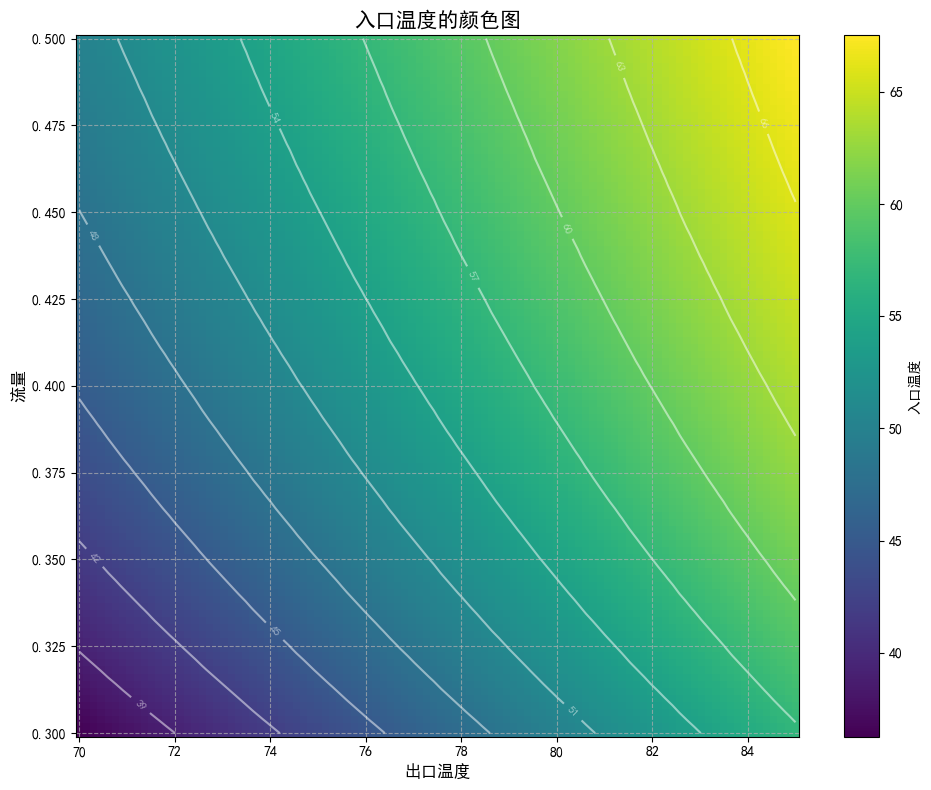

In [7]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

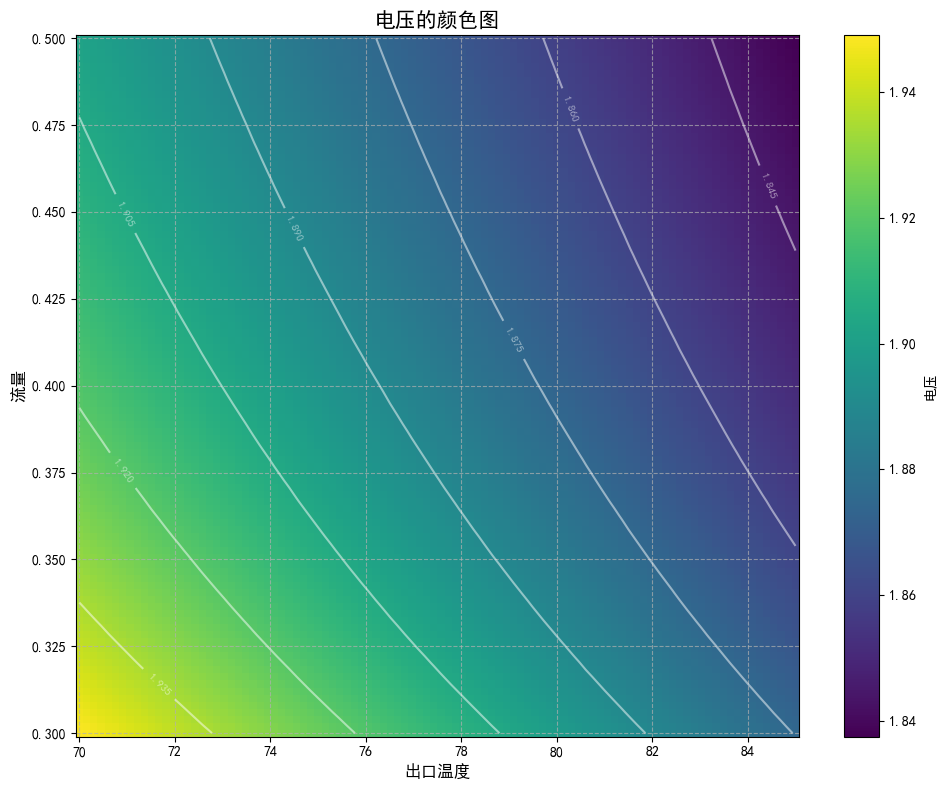

In [ ]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

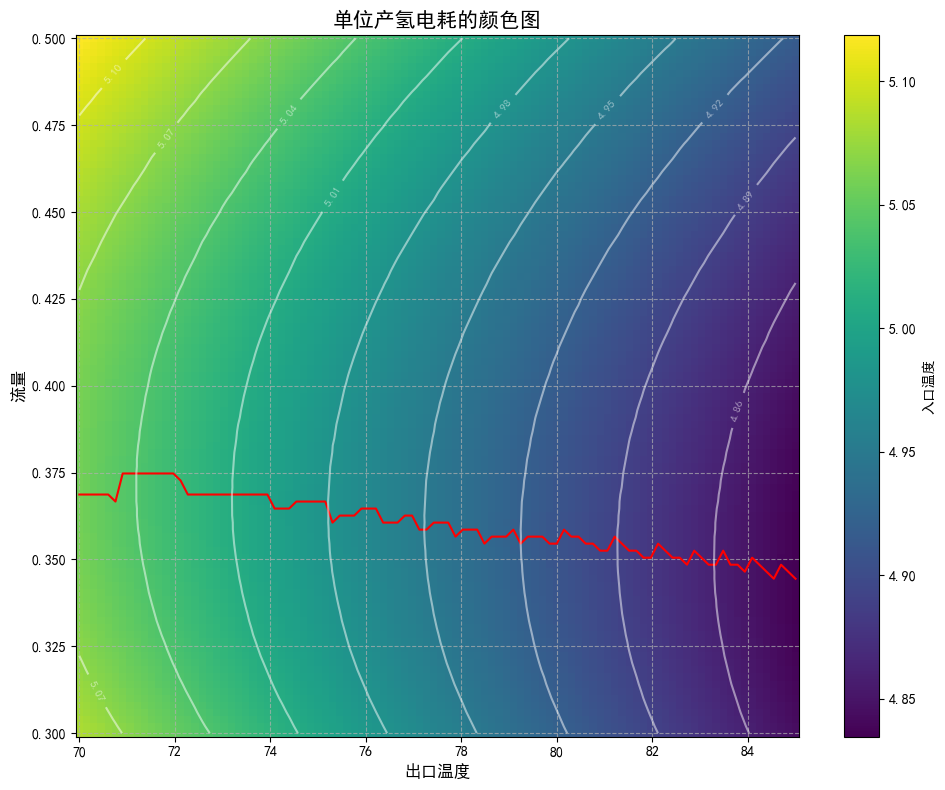

In [39]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array, min_Power_H_lye_flow_array, c='r')

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

In [44]:
# 创建网格数据
temp_out_array_2500 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_2500 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_2500 = np.array([])  # 入口温度记录
V_cell_array_2500 = np.array([])
Power_H_array_2500 = np.array([])
X, Y = np.meshgrid(temp_out_array_2500, lye_flow_array_2500)      # 创建二维网格

for lye_flow in lye_flow_array_2500:
    for temp_out in temp_out_array_2500:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 2500,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_2500 = np.append(lye_temp_array_2500, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 2500,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_2500 = np.append(V_cell_array_2500, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=2500,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_2500 = np.append(Power_H_array_2500, Power_H)


lye_temp_array_2500 = lye_temp_array_2500.reshape(len(lye_flow_array), len(temp_out_array))
V_cell_array_2500 = V_cell_array_2500.reshape(len(lye_flow_array), len(temp_out_array))
Power_H_array_2500 = Power_H_array_2500.reshape(len(lye_flow_array), len(temp_out_array))

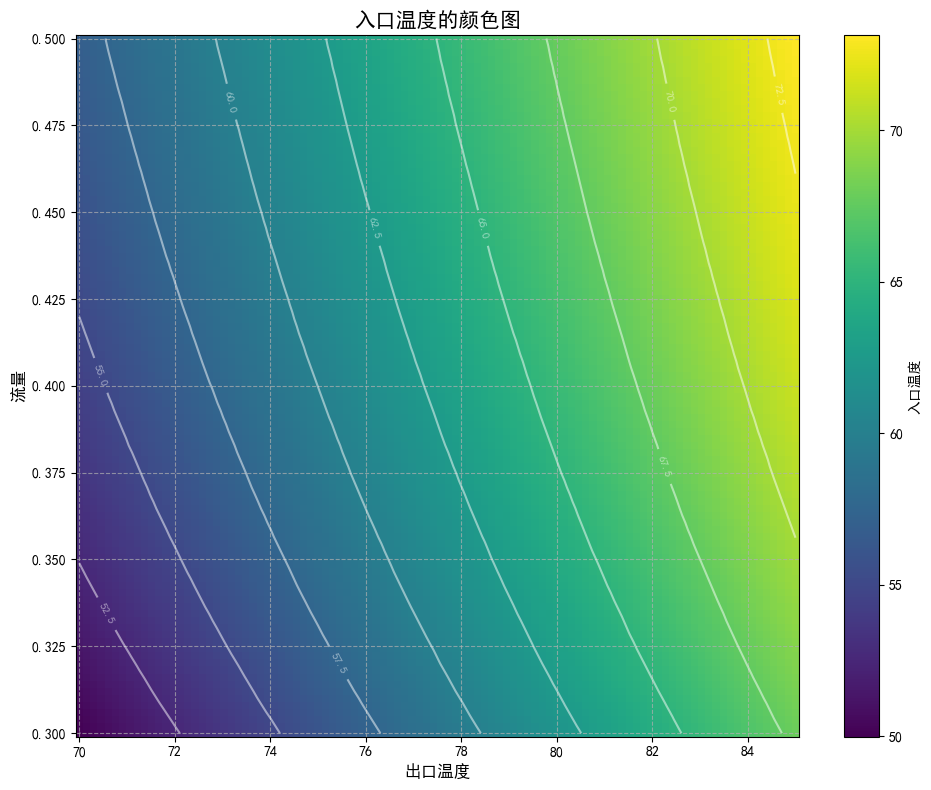

In [48]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

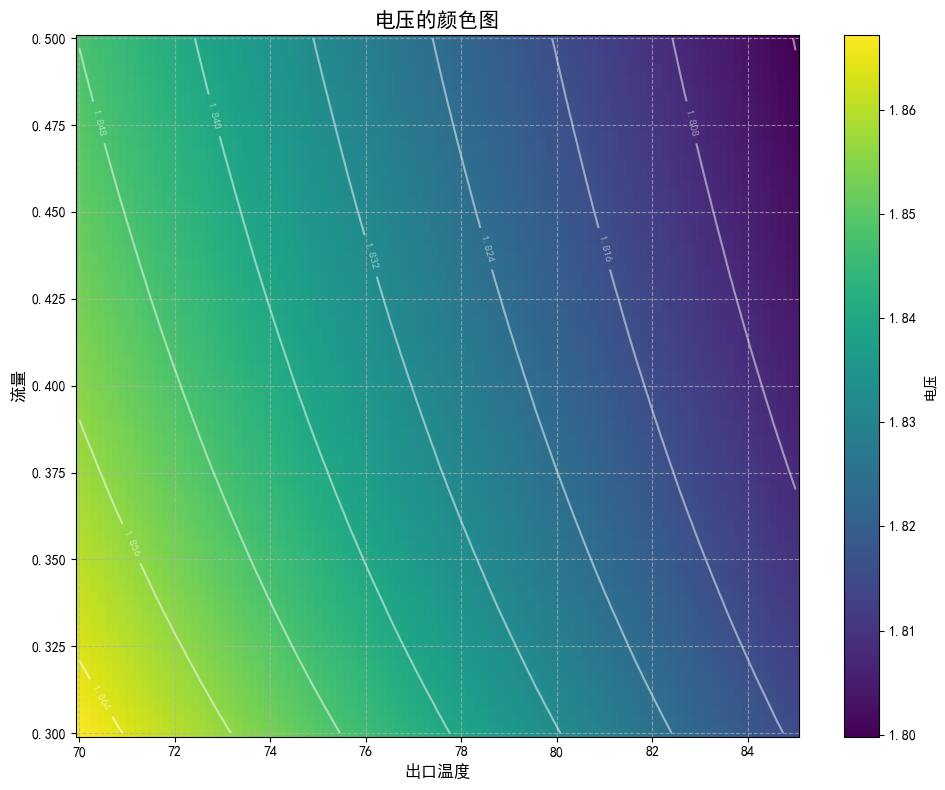

In [49]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

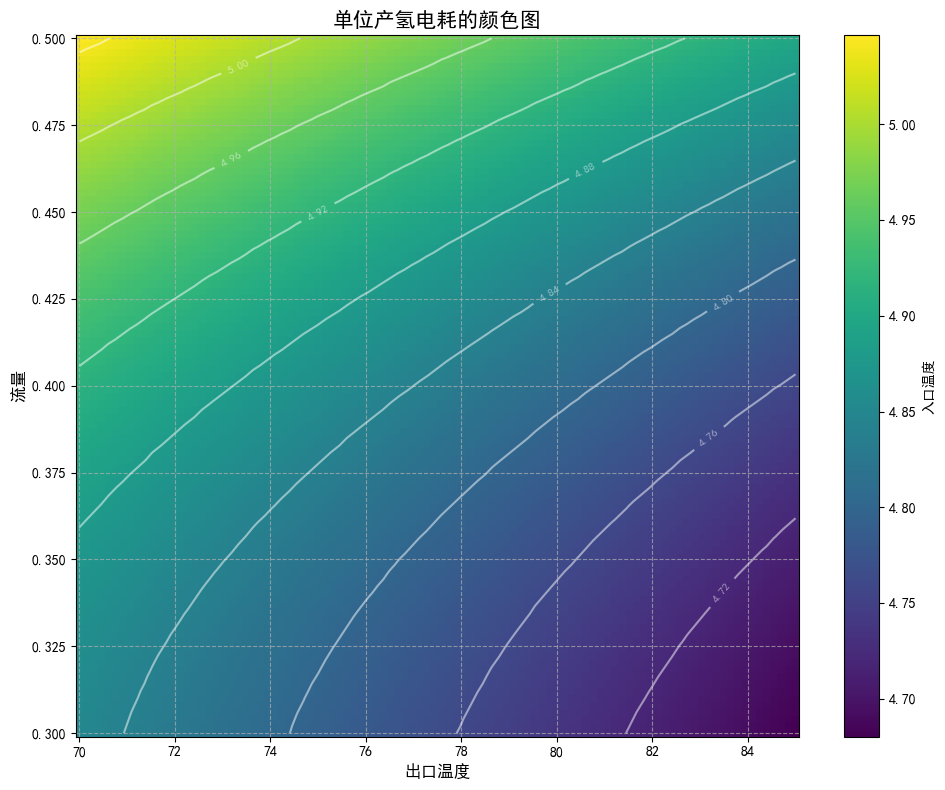

In [50]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

In [51]:
# 创建网格数据
temp_out_array_3000 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_3000 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_3000 = np.array([])  # 入口温度记录
V_cell_array_3000 = np.array([])
Power_H_array_3000 = np.array([])
X, Y = np.meshgrid(temp_out_array_3000, lye_flow_array_3000)      # 创建二维网格

for lye_flow in lye_flow_array_3000:
    for temp_out in temp_out_array_3000:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 3000,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_3000 = np.append(lye_temp_array_3000, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 3000,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_3000 = np.append(V_cell_array_3000, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=3000,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_3000 = np.append(Power_H_array_3000, Power_H)


lye_temp_array_3000 = lye_temp_array_3000.reshape(len(lye_flow_array), len(temp_out_array))
V_cell_array_3000 = V_cell_array_3000.reshape(len(lye_flow_array), len(temp_out_array))
Power_H_array_3000 = Power_H_array_3000.reshape(len(lye_flow_array), len(temp_out_array))

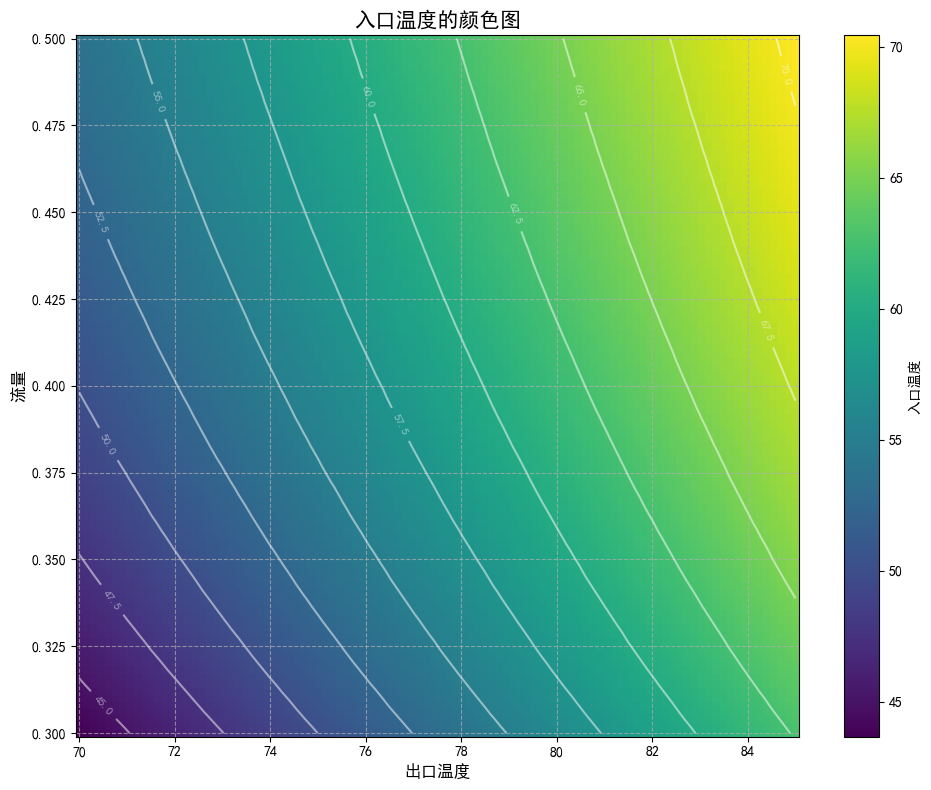

In [54]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

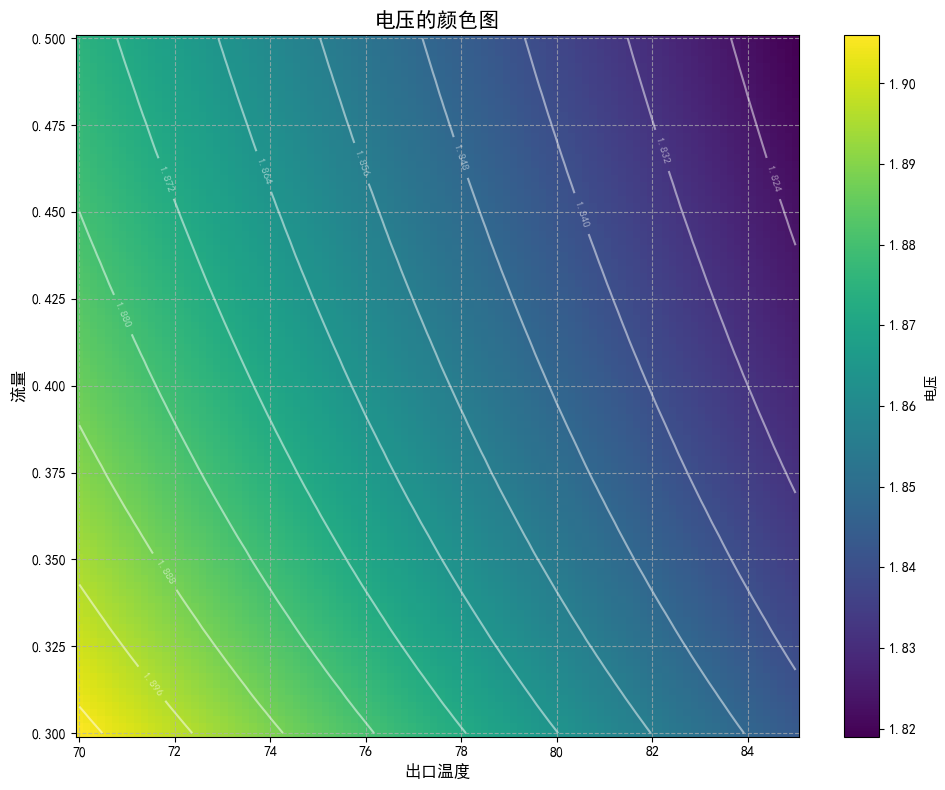

In [55]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

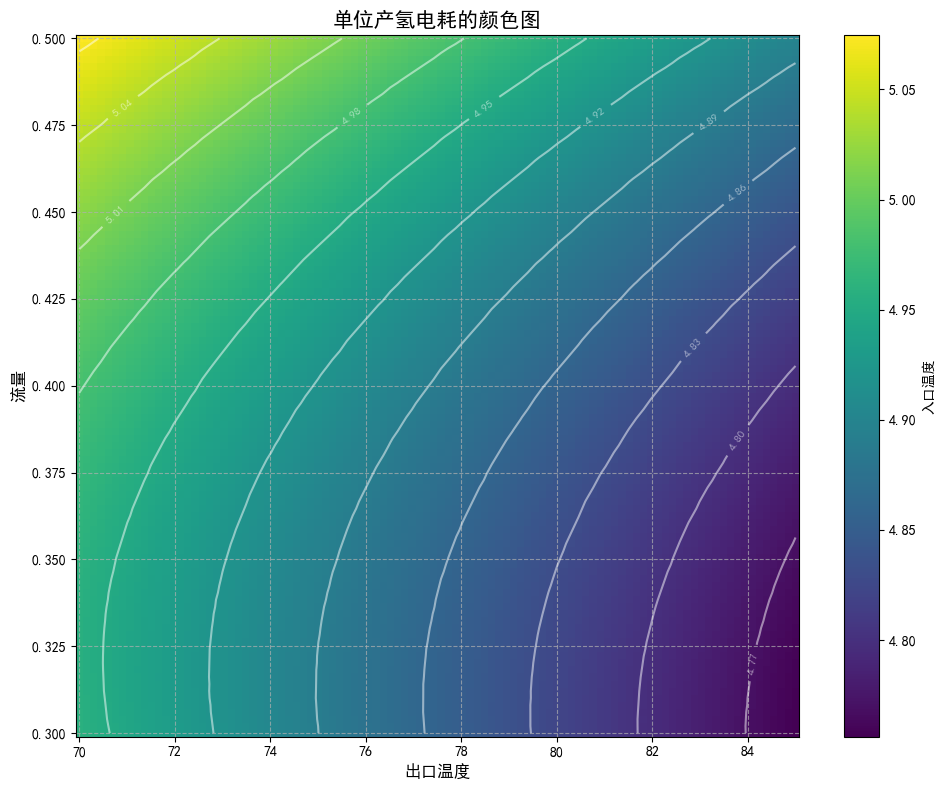

In [56]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()